Project 1: Gradient-based Algorithms and Differentiable Programming
1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$
where $\Delta t$ is a time interval. Further, let the closed-loop controller be

$$
a(t) = f_{\theta}(x(t))
$$
where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad &amp; ||x(T)||^2 \\
\quad &amp; d(t+1) = d(t) + v(t) \Delta t, \\
\quad &amp; v(t+1) = v(t) + a(t) \Delta t, \\
\quad &amp; a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$
While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$.

In the following, we code this problem up with PyTorch, which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.



2. Sample Code
Before you start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through setting->Project: Your Project Name->Project Interpreter->Install (the little plus sign to the right of the window).

3. A Better Problem Formulation
Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc.
Better dynamical model, e.g., drag
Constraints in state and action spaces
Controller design for a distribution of initial states rather than one
Randomness in dynamics, sensing, etc.
Discontinuity in modeling so that gradient cannot be computed, e.g., mechanical failures.
In this project, please choose at least one aspect from 1 to 5 from the list to improve your problem formulation and solve the resultant problem. We will address 6 when we talk about reinforcement learning.

Here is one example of problem formulation when we consider randomness in dynamics and initial states:

$$
\begin{aligned}
\min_{\theta} \quad &amp; \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad &amp; d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad &amp; v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad &amp; a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad &amp; x(1) \sim \Pr(x(1))
\end{aligned}
$$
Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$, $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad &amp; \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad &amp; d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad &amp; v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad &amp; a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$
The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized.

4. Grading
(30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

(40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

(30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

(Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing.

In [24]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [25]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 9.8  # gravity constant g = 9.8 m/s^2
BOOST_ACCEL = 15  # assuming thrust constant to be 15 m/s^2 as it ususally more than g 

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

In [26]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """
       
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed... 
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust
        # Note: Same reason as above. Need a 2-by-1 tensor.
        delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action
        
        temp = delta_state
        
        """"
        Drag force: D = Cd * A * .5 * r * V^2
        Rocket in assumption is falcon 9
        Cd = 0.25 (Drag co-efficint of long cyclinder with a cone nose) ref: https://space.stackexchange.com/questions/16883/whats-the-atmospheric-drag-coefficient-of-a-falcon-9-at-launch-sub-sonic-larg
        A = pi * 12 feet ^2 (Diameter of falcon 9) = 34 m^2
        r = 850 kg/m^3 (Density of steel)
        V = velocity = delta state
        m = 549054 Kg (Mass of falcon 9)
        
        D = 0.25 * 34 * 0.5 * 850 * delta_state**2
        
        also applying force balance on the rocket
        
        m * DRAG_DECEL (deceleration due to drag) = D
        DRAG_DECEL = 0.00658 * delta_state**2
        
        """
        #Updating drag
        DRAG_DECEL = 0.00658 * temp**2
        
        #Re-calculating new velocity
        delta_state = DRAG_DECEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # Update velocity
        state = state + delta_state + delta_state_gravity
        
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible. Do not use element-wise operators as they are considered inplace.
        step_mat = t.tensor([[1., FRAME_TIME],
                            [0., 1.]])
        state = t.matmul(step_mat, state)

        return state

In [27]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Tanh(),#added new layer
            nn.Linear(dim_hidden, dim_hidden),#added new layer
            nn.Tanh(),#added new layer
            nn.Tanh(),#added a new layer
            nn.Linear(dim_hidden, dim_output),#added new hidden layer
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [28]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0.]  # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2

In [29]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('_______________________________________________________________________________________________________________')
            print('\nIteration number:\t',epoch+1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        plt.title('Distance vs velocity plot')
        plt.xlabel('Distance')
        plt.ylabel('Velocity')
        plt.plot(x, y)
        plt.show()

_______________________________________________________________________________________________________________

Iteration number:	 1
loss: 254811.188


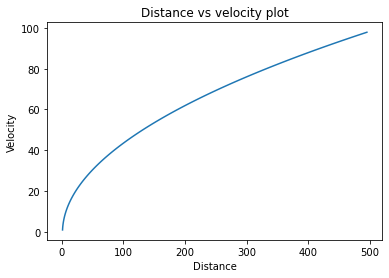

_______________________________________________________________________________________________________________

Iteration number:	 2
loss: 254792.984


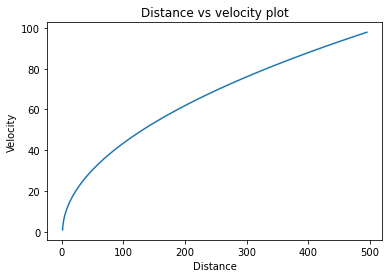

_______________________________________________________________________________________________________________

Iteration number:	 3
loss: 254782.359


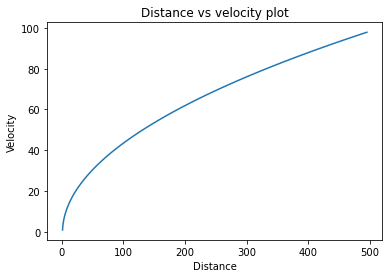

_______________________________________________________________________________________________________________

Iteration number:	 4
loss: 254775.469


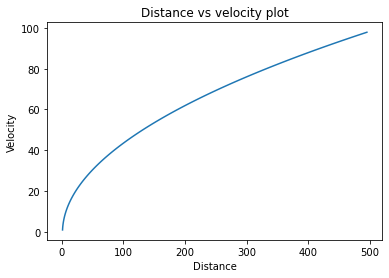

_______________________________________________________________________________________________________________

Iteration number:	 5
loss: 254769.734


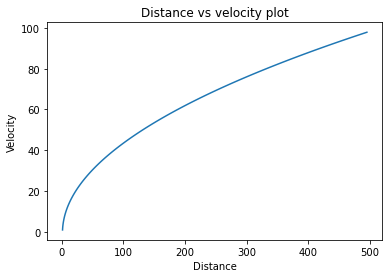

_______________________________________________________________________________________________________________

Iteration number:	 6
loss: 254767.531


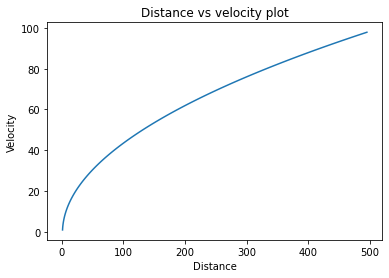

_______________________________________________________________________________________________________________

Iteration number:	 7
loss: 254765.156


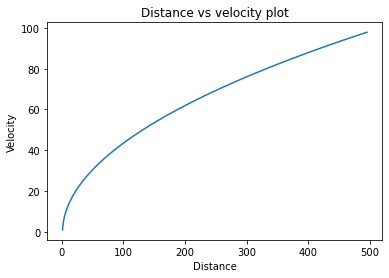

_______________________________________________________________________________________________________________

Iteration number:	 8
loss: 254763.391


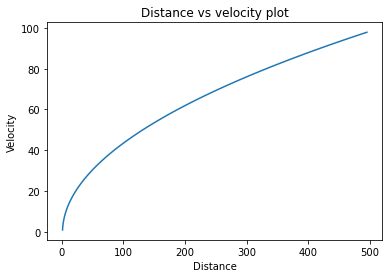

_______________________________________________________________________________________________________________

Iteration number:	 9
loss: 254763.062


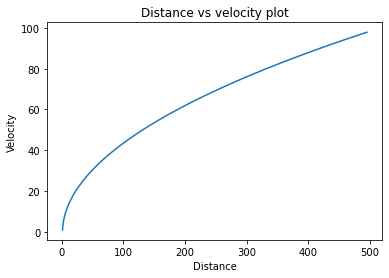

_______________________________________________________________________________________________________________

Iteration number:	 10
loss: 254762.203


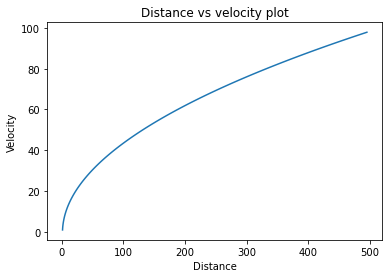

_______________________________________________________________________________________________________________

Iteration number:	 11
loss: 254761.984


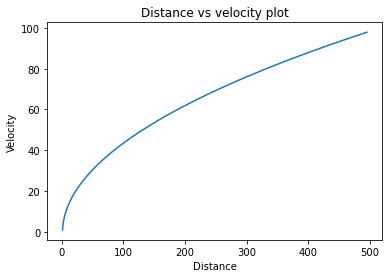

_______________________________________________________________________________________________________________

Iteration number:	 12
loss: 254759.500


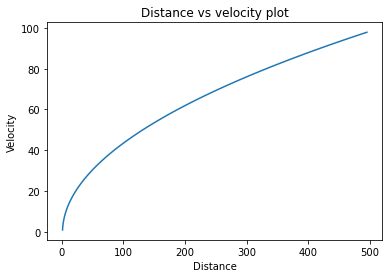

_______________________________________________________________________________________________________________

Iteration number:	 13
loss: 254759.234


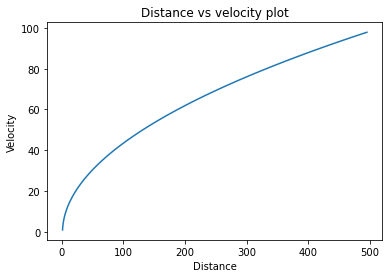

_______________________________________________________________________________________________________________

Iteration number:	 14
loss: 254759.234


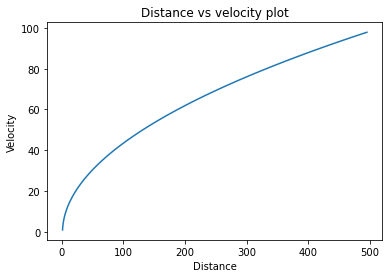

_______________________________________________________________________________________________________________

Iteration number:	 15
loss: 254758.969


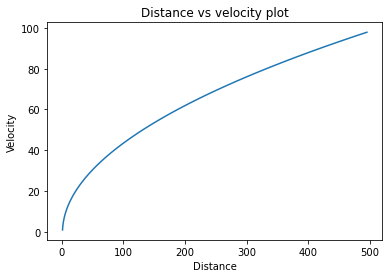

_______________________________________________________________________________________________________________

Iteration number:	 16
loss: 254758.812


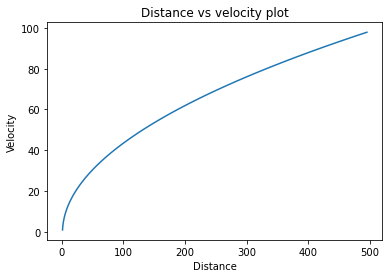

_______________________________________________________________________________________________________________

Iteration number:	 17
loss: 254758.031


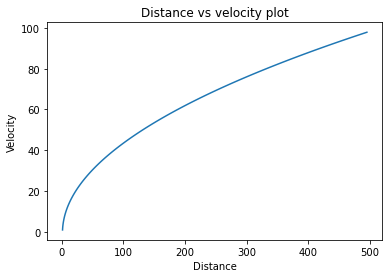

_______________________________________________________________________________________________________________

Iteration number:	 18
loss: 254758.031


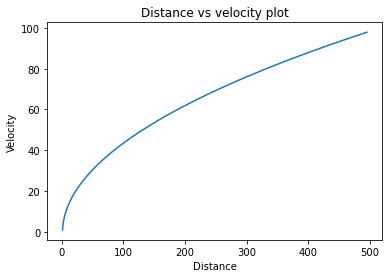

_______________________________________________________________________________________________________________

Iteration number:	 19
loss: 254757.797


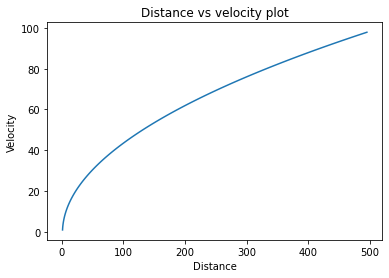

_______________________________________________________________________________________________________________

Iteration number:	 20
loss: 254757.562


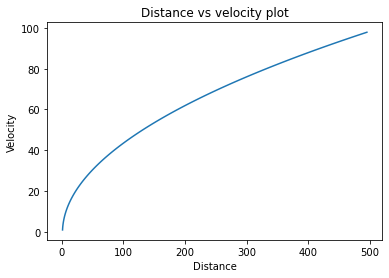

_______________________________________________________________________________________________________________

Iteration number:	 21
loss: 254757.000


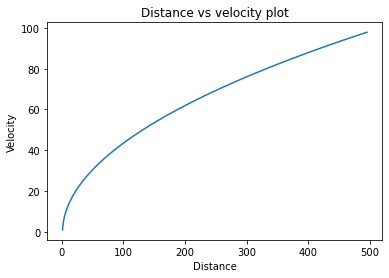

_______________________________________________________________________________________________________________

Iteration number:	 22
loss: 254756.969


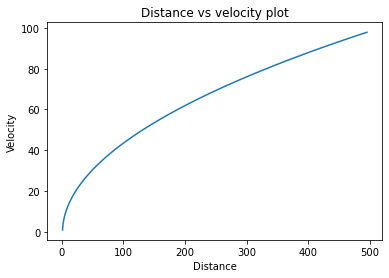

_______________________________________________________________________________________________________________

Iteration number:	 23
loss: 254756.969


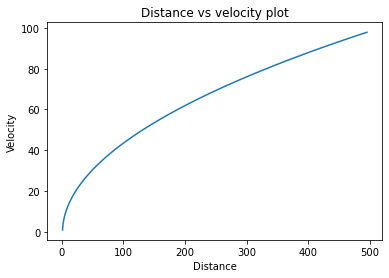

_______________________________________________________________________________________________________________

Iteration number:	 24
loss: 254756.969


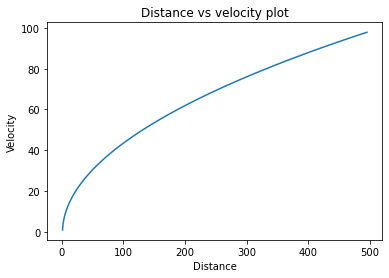

_______________________________________________________________________________________________________________

Iteration number:	 25
loss: 254756.656


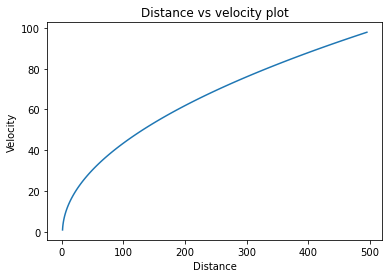

_______________________________________________________________________________________________________________

Iteration number:	 26
loss: 254756.656


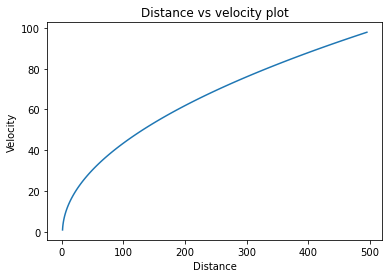

_______________________________________________________________________________________________________________

Iteration number:	 27
loss: 254756.656


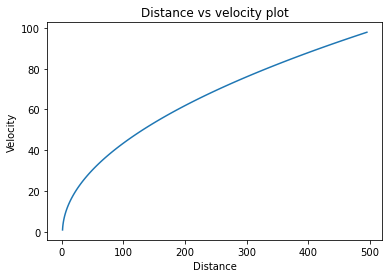

_______________________________________________________________________________________________________________

Iteration number:	 28
loss: 254756.500


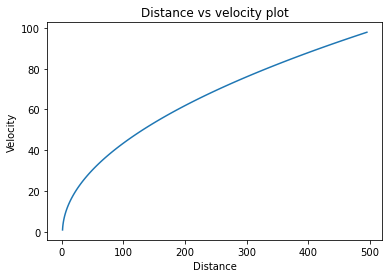

_______________________________________________________________________________________________________________

Iteration number:	 29
loss: 254755.812


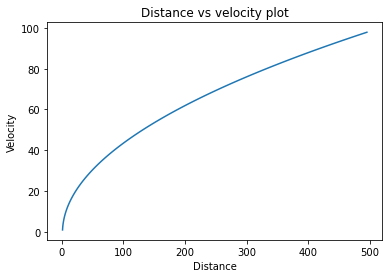

_______________________________________________________________________________________________________________

Iteration number:	 30
loss: 254755.750


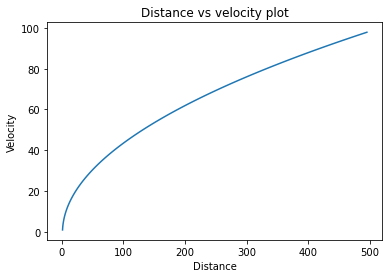

_______________________________________________________________________________________________________________

Iteration number:	 31
loss: 254755.750


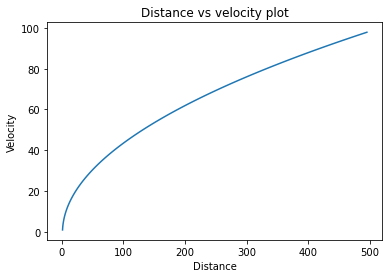

_______________________________________________________________________________________________________________

Iteration number:	 32
loss: 254755.750


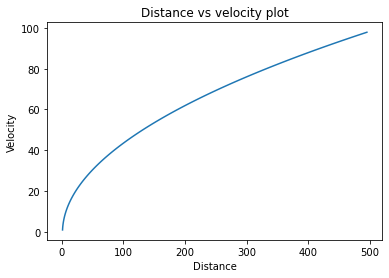

_______________________________________________________________________________________________________________

Iteration number:	 33
loss: 254755.750


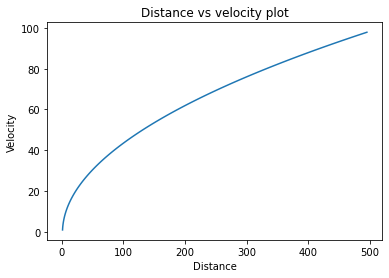

_______________________________________________________________________________________________________________

Iteration number:	 34
loss: 254755.750


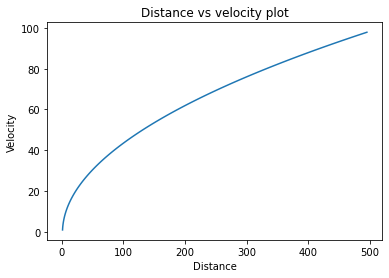

_______________________________________________________________________________________________________________

Iteration number:	 35
loss: 254755.469


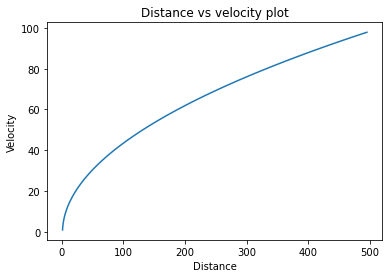

_______________________________________________________________________________________________________________

Iteration number:	 36
loss: 254755.469


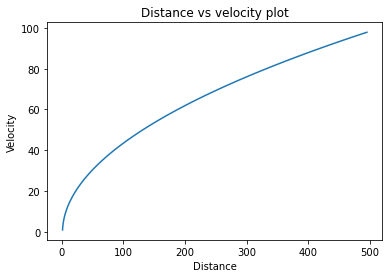

_______________________________________________________________________________________________________________

Iteration number:	 37
loss: 254755.469


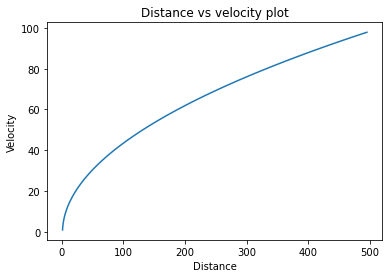

_______________________________________________________________________________________________________________

Iteration number:	 38
loss: 254755.266


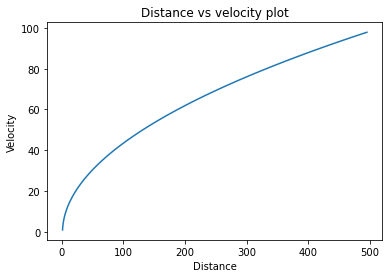

_______________________________________________________________________________________________________________

Iteration number:	 39
loss: 254755.266


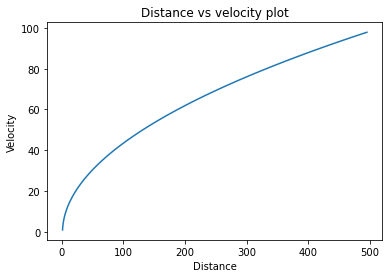

_______________________________________________________________________________________________________________

Iteration number:	 40
loss: 254755.266


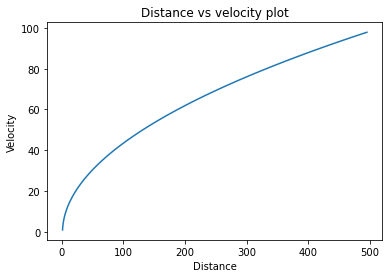

_______________________________________________________________________________________________________________

Iteration number:	 41
loss: 254755.266


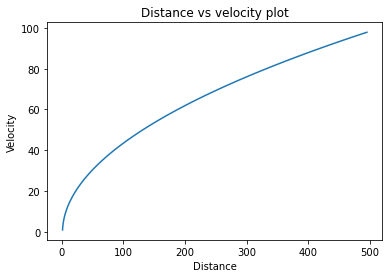

_______________________________________________________________________________________________________________

Iteration number:	 42
loss: 254755.266


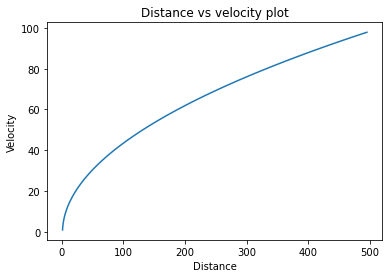

_______________________________________________________________________________________________________________

Iteration number:	 43
loss: 254755.172


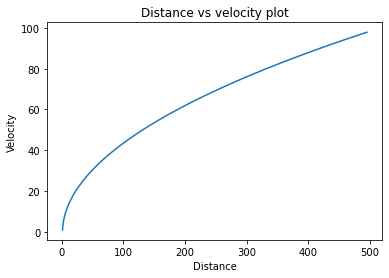

_______________________________________________________________________________________________________________

Iteration number:	 44
loss: 254755.172


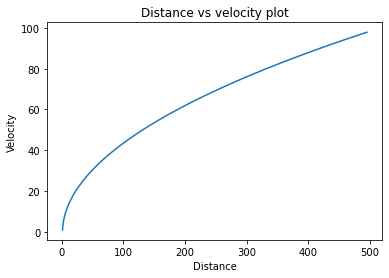

_______________________________________________________________________________________________________________

Iteration number:	 45
loss: 254755.172


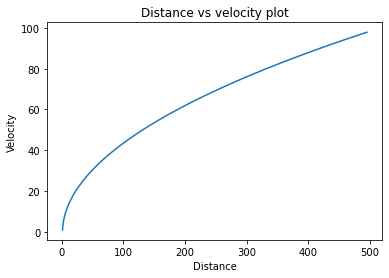

_______________________________________________________________________________________________________________

Iteration number:	 46
loss: 254755.172


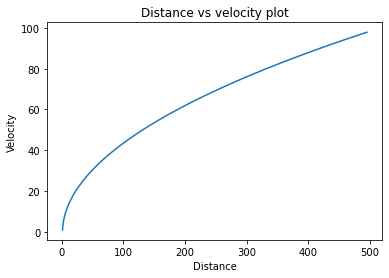

_______________________________________________________________________________________________________________

Iteration number:	 47
loss: 254755.172


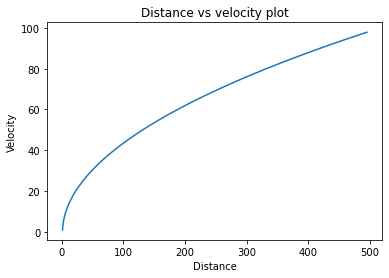

_______________________________________________________________________________________________________________

Iteration number:	 48
loss: 254755.172


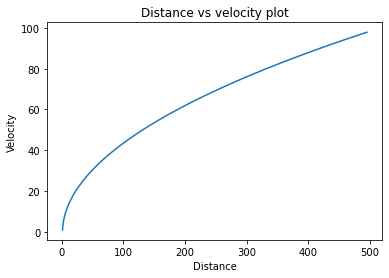

_______________________________________________________________________________________________________________

Iteration number:	 49
loss: 254754.828


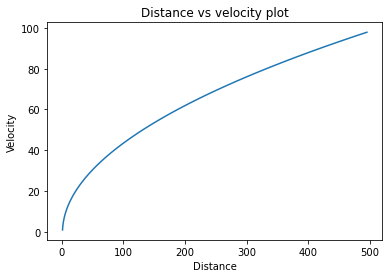

_______________________________________________________________________________________________________________

Iteration number:	 50
loss: 254754.828


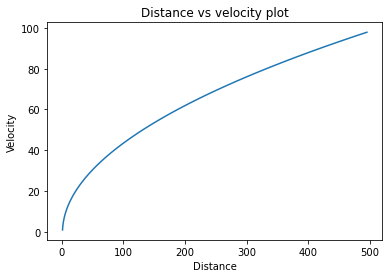

In [30]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(50)  # solve the optimization problem